

# Expected Return Timing

The most classic timing strategies are motivated by the fact that high dividend yield periods seems to be followed by above average returns

The plot shows the dividend-yield of the stock market overlayed with the future 7 year returns
![MVfrontier](https://github.com/amoreira2/Fin418/blob/main/assets/plots/Timing1.jpg?raw=1)

It tell us that in this sample, periods when the dividend yield was high were periods where the returns were really high going forward.

This might be intuitive to you, but it is really a fact that puzzled lots of people and earned Robert Shiller a nobel prize

<img src="https://som.yale.edu/sites/default/files/styles/square_1280/public/profile_pictures/shiller-bob.jpg.webp?itok=TgThr2LT" alt="Rober shiller" style="width: 20%;">


It tells us that when the price (per dividend) is low what actually happens is NOT that the dividends go down going forward which would be intuitive--if the price is low is probably because payouts will be low-- but instead prices go up--meaning expected returns were high!

So this suggests EXPECTED returns to invest in the market change a lot overtime.

A trading strategy that exploits this would have weights that depend on the dividend yield signal.






## Libraries and Functions

In [ ]:
#!pip install wrds

In [ ]:

#import wrds

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline


import pandas_datareader.data as DataReader

def get_factors(factors='CAPM',freq='daily'):

    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]


        df_factor = daily_data[['RF','Mkt-RF']]
    elif factors=='FF3':
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = DataReader.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')

    else:
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = DataReader.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')
        fama_french = DataReader.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp()+ pd.offsets.MonthEnd(0))
    else:
        df_factor.index = pd.to_datetime(df_factor.index)



    return df_factor/100

## Our Data

- Monthly data one the market portfolio returns and it's dividend yield

In [3]:
# uncomment to use WRDS
# db = wrds.Connection()
# crsp_sql = f"""
#     SELECT date, vwretd, vwretx
#     FROM crsp.msi
#     ORDER BY date;
# """
# crsp = db.raw_sql(crsp_sql, date_cols=['date'])
# crsp['dp'] = (1.0 + crsp['vwretd']) / (1.0 + crsp['vwretx']) - 1.0
# crsp = crsp.set_index('date')
# crsp.to_csv('../../assets/data/Markettiming_data1.csv')
#######################################
crsp=pd.read_csv('https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/Markettiming_data1.csv')
crsp.date=pd.to_datetime(crsp.date)
crsp.set_index('date',inplace=True)
crsp

,vwretd,vwretx,dp
date,,,
1925-12-31,NaN,NaN,NaN
1926-01-30,0.000561,-0.001395,0.001959
1926-02-27,-0.033046,-0.036587,0.003675
1926-03-31,-0.064002,-0.070021,0.006472
1926-04-30,0.037029,0.034043,0.002888
...,...,...,...
2024-08-30,0.021572,0.020203,0.001342
2024-09-30,0.020969,0.019485,0.001456
2024-10-31,-0.008298,-0.009139,0.000849


## Dividend yield or (Valuation ratio)

- Dividend yields went from 4%-7% in the start of the sample (1930's) to around 2% now
- We will now look at the relationship between dividend yields and  5-year ahead returns
- That is, I will ask the regression to tell me: if I see a high dividend-yield what does typically happen with the returns of my investment in the market if I buy it and hold it for 5 years
- Because this story is mostly about risk-premia we will take out the risk-free rate

⚡ ⏰ Question: Group A - B ⚡

- Explain the economics of why variation in dividend yields would predict returns and with which sign
- Explain the economics of why variation in dividend yields would NOT predict returns. What should it predict in this case?

<Axes: xlabel='date'>

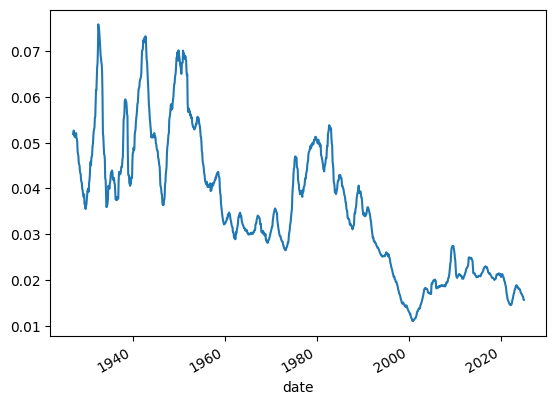

In [4]:
# we will average over 1 year to get rid of seasonality and noise in general
# we will also multiply by 12 to get the annualized dividend yield
(crsp.dp.rolling(window=12).mean()*12).plot()

## Return Predictability?

/tmp/ipython-input-719732661.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
/tmp/ipython-input-719732661.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")


np.float64(0.36709404503033916)

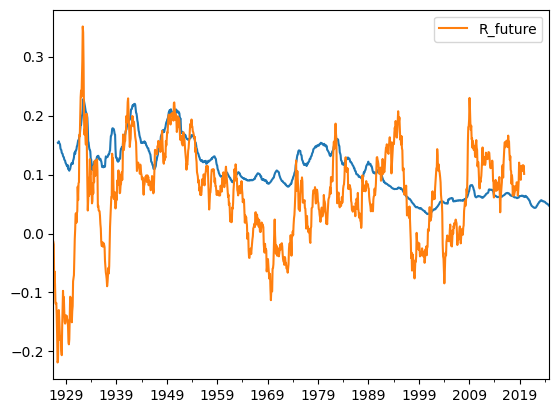

In [5]:
df = get_factors('CAPM', freq='monthly').dropna()

# We align the indices of the CRSP data and the Fama-French data
# they are both monthly data but wrds has the actual last trading date of the month while
# the Fama-French data has the last calendar day of the month

crsp.index = crsp.index+pd.offsets.MonthEnd(0)
years=5
merged_data = crsp.merge(df[['RF']], left_index=True, right_index=True)
# here we cumulate the excess returns over the next 5 years
# we do that by first taking a rolling product of gross returns--the windown is backwards looking
# then we shift the result by 5 years to get the future returns
merged_data['R_future']= (1+merged_data['vwretd']-merged_data['RF']).rolling(window=years*12).apply(np.prod).shift(-years*12)**(1/years)-1
# I am also annualizing the returns back so the units are right

# I averaging the dividend yield to get rid of seasonality and noise
# a simiar possibility would be to add the dividends for the last 12 months and divide by the price at the end of the period
# I am multiplying by 12 to get the annualized dividend yield
merged_data['dp_avg'] = merged_data.dp.rolling(window=12).mean()*12
#finally I multiply the dividend yield by 3 to make it more visible in the plot
ax=(merged_data['dp_avg']*3).plot()
merged_data[['R_future']].plot(ax=ax)
#raw correlation suggests interesting relationship
# this is predictive
(merged_data['dp_avg']).corr(merged_data['R_future'])

## How do you test if the signal works?

- You start with some signal that you know in date $t$
- Estimate the forecasting regression

$$ r_{t+1}=a+b *signal_t+u_{t+1}$$

- The difference from factor models is that the relationship is NOT contemporaneous
- The whole point is to use the fact that you **know the signal ahead of time**
- That is the signal at date $t$ has information about the return in data $t+1$ (or some longer horizon)
- In fact what we will do below is to try to predict the next 5 years


$$ r_{t\rightarrow t+60}=a+b *signal_t+u_{t+1}$$

- We will be looking at the b coefficient, it's standard errors and the r-squared of this regression


- Is the R-squared meaningful AND the b is well estimate and different from zero?
    - If the answer is no: STOP, the signal does not work even in sample!
    - If yes, then you kick the tires more...



In [6]:
# lets run the regression
X = sm.add_constant(merged_data['dp_avg'] )
model = sm.OLS(merged_data['R_future'], X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               R_future   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     172.7
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           9.01e-37
Time:                        15:26:03   Log-Likelihood:                 1305.7
No. Observations:                1111   AIC:                            -2607.
Df Residuals:                    1109   BIC:                            -2597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0069      0.006     -1.140      0.2

## Too good to be true

WOW! Look at this t-stat!

What do you think? Can we really take it to the bank?

- Note that we have overlapping windows. Better adjust this standard errors

⚡ ⏰ Question: Group C-D ⚡

- Think why overlapping will mess with standard errors
- Try to think of examples and be concrete
- What is the objective of the standard errors?

In [8]:

X = sm.add_constant(merged_data['dp_avg'] )
model = sm.OLS(merged_data['R_future'], X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': years*12})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               R_future   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     8.623
Date:                Mon, 22 Sep 2025   Prob (F-statistic):            0.00339
Time:                        15:28:25   Log-Likelihood:                 1305.7
No. Observations:                1111   AIC:                            -2607.
Df Residuals:                    1109   BIC:                            -2597.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0069      0.030     -0.233      0.8

## Evaluation 1: Adjusting the R-squared

In sample, this looks pretty good

BUT.......

Obviously we cannot trade on the same data we estimate our model

So we will need to kick the tires more. 

For now we will do something simple

- Estimation vs Test sample
- We then we will look at an adjusted R-squared and also a trading strategy format

One thing that people do to evaluate these forecasting regressions is look at the R-squared **out of sample** relative to some benchmark $\mu_{t}$.

- Typically a regression R-squared has the average--but we cannot use the average out of sample

⚡ ⏰ Question: Group E-F⚡

- Why not? Explain the need to use some benchmark $\mu_{t}$ instead of the average? 

$$R^2_{OOS}=1-\frac{\sum(r_{t+1}-(a+b *signal_t))^2}{\sum(r_{t+1}-\mu_{benchmark})^2}$$

- Just need to adjust forecast relative to the standard R-squared formula

$$R^2_{Standard}=1-\frac{\sum(r_{t+1}-(a+b *signal_t))^2}{\sum(r_{t+1}-Average(r_{t+1}))^2}$$



np.float64(-1.9299831475318894)

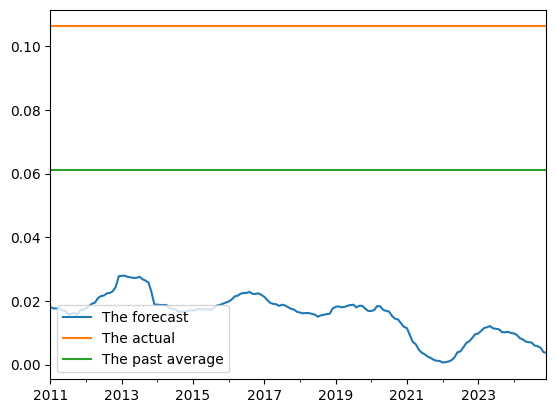

In [ ]:
Estimation_sample=merged_data[:'2010'].copy()
Test_sample=merged_data['2011':].copy()


X = sm.add_constant(Estimation_sample['dp_avg'] )
model = sm.OLS(Estimation_sample['R_future'], X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': years*12})



Test_sample['premium_forecast']=(model.params['const']+model.params['dp_avg']*Test_sample['dp_avg'])
premium_benchmark=(Estimation_sample['R_future']).mean()
Test_sample['premium_forecast'].plot()
(Test_sample['premium_forecast']*0+(Test_sample['R_future']).mean()).plot() # what is going on here?
(Test_sample['premium_forecast']*0+premium_benchmark).plot() # what is going on here?
plt.legend(['The forecast','The actual','The past average'])


#What does this say? What do we wanted this number to look like?

##############################################
# The out-of-sample R2
# R2_TS=1-((Test_sample['R_future']-(Test_sample['premium_forecast']))**2).sum()/((Test_sample['R_future']-premium_benchmark)**2).sum()
# R2_TS

## Trading strategy Implementation


A less "academicy" way is to simply see how well the trading strategy does out of sample

For example you would have a weight

$$x_t=\frac{\mu_t}{\gamma \sigma_t^2}=\frac{(a+b\frac{d_t}{p_t})}{\gamma \sigma^2}$$

- where a b are  the regression coefficient
on the market excess return, and $a+b\frac{d_t}{p_t}$ is our premium forecast
- $\gamma$ is the risk-aversion and $\sigma$ is the volatility of the asset (we are assuming it is constant).


So your strategy return is

$$r_{t+1}=(1-x_t)r^f_{t+1}+x_tr_{t+1}^{mkt}$$

Where you would use to control your average exposure to the market.

Or more simply

$$r_{t+1}=r^f_{t+1}+x_t(r_{t+1}^{mkt}-r^f_{t+1})$$


If x<1, invest some in the risk-free rate, if x>1, borrow to fund a bigger position in the risky asset

Text(0, 0.5, 'Weight on the market portfolio')

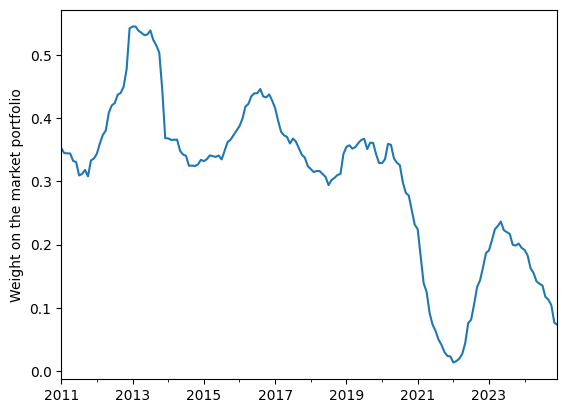

In [39]:

gamma=2
vol=0.16

Test_sample['weight']=Test_sample['premium_forecast']/(gamma*vol**2)

Test_sample['weight'].plot()
plt.ylabel('Weight on the market portfolio')

## Performance

- Note that the denominator here $\gamma \sigma^2$ is only impacting your average position in the asset. 
- An alternative it to pick it so that you have some average desired position in the asset

We can now directly look at it's performance relative to a buy and hold strategy

<Axes: >

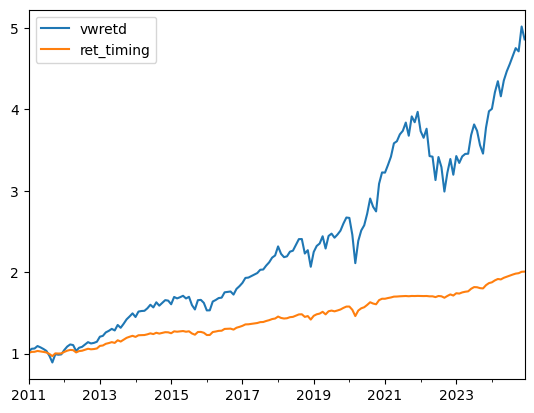

In [40]:

Test_sample['ret_timing']=Test_sample['RF']+Test_sample['weight']*(Test_sample['vwretd']-Test_sample['RF'])

(1+Test_sample[['vwretd','ret_timing']]).cumprod().plot()

## What is the right benchmark?

But is this the right benchmark for performance?

Here is a different one

Here we use the average return in the estimation sample as our measure of risk-premium

<Axes: >

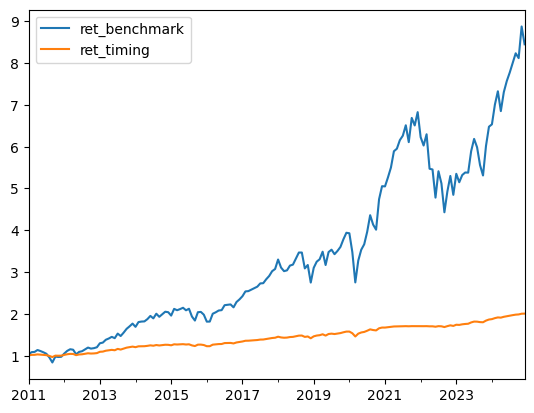

In [41]:
premium_benchmark=(Estimation_sample['vwretd']-Estimation_sample['RF']).mean()*12
Test_sample['weight_benchmark']=premium_benchmark/(gamma*vol**2)
Test_sample['ret_benchmark']=Test_sample['RF']+Test_sample['weight_benchmark']*(Test_sample['vwretd']-Test_sample['RF'])
(1+Test_sample[['ret_benchmark','ret_timing']]).cumprod().plot()

## Pricking the Right Benchmark

⚡ ⏰ Question: Group G-A⚡
- Complete the blank spaces!

For a timing strategy that trades on a single factor the approach is straight forward

Run a regression of the timing strategy returns on the buy and hold factor that the strategy times. And look at the _______.

Basically this will be asking whether the timing adds any value once you adjust for the average ______ it has to the _____. The right benchmark is a portfolio with the same average ___ as the timing strategy. This approach cleanly separates the timing aspect from just differences in ________.

The relevant metric for us is if the strategy had ______ in the _____ sample.

When we run this regression we making sure to always take the ____ so we have ____ returns in both sides and the ____ has clear interpretation.



In [42]:
X = sm.add_constant(Test_sample['vwretd']-Test_sample['RF'])
model = sm.OLS(Test_sample['ret_timing']-Test_sample['RF'], X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     774.2
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           2.12e-64
Time:                        16:02:32   Log-Likelihood:                 641.85
No. Observations:                 168   AIC:                            -1280.
Df Residuals:                     166   BIC:                            -1273.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.620      0.1

## Buy and Hold Sharpe Ratios

You could also look directly at Sharpe Ratios and compare the Buy and hold with the timing strategy

To the extent that timing works, you should be harvesting more premium per unit of risk you are taking

Variation in beta will simply move expected returns and volatility together and be Sharpe Ratio neutral.

To boost SR you have to have alpha, so the timing has to be doing something

In [44]:
display((Test_sample['ret_timing']-Test_sample['RF']).mean()*12/((Test_sample['ret_timing']-Test_sample['RF']).std()*(12**0.5)))
display((Test_sample['vwretd']-Test_sample['RF']).mean()*12/((Test_sample['vwretd']-Test_sample['RF']).std()*(12**0.5)))
# try to break in different periods. Are these patterns stable?

np.float64(0.8844794543995637)

np.float64(0.7686936517237514)

## What is the conclusion here?



The summary is
- This regression has many issues and academics have spent a lot of time on it
- There is a relationship but it is weak and unstable
- You absolutely cannot take it to the bank
- The big issues are:
  - the variable dividend yield is extremely persistent, so we do not have that much variation in it. Just a few data points even in a long sample
  - The return are overlapping, so when we cumulate the returns we are really double counting the number of observations, so the traditional standard errors are totally off
  - Traditional--but not bullet proof is to use an adjusted standard errors like HAC with a window consistent with the rolling window. We  did that and does make a huge difference


⚡ ⏰ Question: Group B-C⚡

- What is another big issue that these very long term regressions have? We haven't explicitly discussed but it is the biggest one.
- Why the past relationship would not hold in the future?






## Going Deeper
if you are interested in digging further see

>John Y. Campbell, Samuel B. Thompson, Predicting Excess Stock Returns Out of Sample: Can Anything Beat the Historical Average?, The Review of Financial Studies, Volume 21, Issue 4, July 2008, Pages 1509–1531, https://doi.org/10.1093/rfs/hhm055

- We refer to the dividend-yield as a signal

- There are many other signals that have been show to predict market returns-- in the past

- Harder to know which ones work right now


⚡ ⏰ Question: Group D-E⚡

Tell me a story of why each of these signals might predict stock market returns and with which sign

- Some of the signals are

    - Short interest (The size of short positions relative to the overall market)

    - Variance risk premium (VIX-squared-Realized Variance)

    - Equity issuing activity (fraction of the market being sold)

    - Aggregate accruals

    - Credit spread: difference in yield between maturity matched BBB bonds and treasury bonds
    
    - Term spread: Difference in yield between a long term bond and a short term bond

## 📝 Key Takeaways

-  To time a factor you need a signal that predicts future returns

-  Predicting in sample is a nice start--but the relationship has to be stable enough so you can predict out of sample  

-  To measure this out of sample predictability you can do two things
    - look at our of sample R-squared using some naive average like past average return as a benchmark
    - Construct a trading strategy in see how it performs

- Once you have the trading strategy we are back on the ground that we know well. What do we look at?
    - Alphas
    - Sharpe Ratios

- Dividend yield (or CAPE) is really not great because it is so persistent, so you need really large samples to say anything--but you can apply this machinery to any other predictors!
---